In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load datasets
trader_df = pd.read_csv('/kaggle/input/history/historical_data.csv')
sentiment_df = pd.read_csv('/kaggle/input/history/fear_greed_index.csv')


In [11]:
# Convert trader timestamps to date
trader_df['Date'] = pd.to_datetime(trader_df['Timestamp IST'], errors='coerce').dt.date

# Convert sentiment date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

# Merge on date
merged_df = pd.merge(trader_df, sentiment_df[['date', 'value', 'classification']],
                     left_on='Date', right_on='date', how='left')
merged_df = merged_df.dropna(subset=['classification'])


In [12]:
summary_by_sentiment = merged_df.groupby('classification').agg(
    avg_closed_pnl=('Closed PnL', 'mean'),
    total_trades=('Account', 'count'),
    total_buy=('Side', lambda x: (x == 'BUY').sum()),
    total_sell=('Side', lambda x: (x == 'SELL').sum())
).reset_index()
print(summary_by_sentiment)


  classification  avg_closed_pnl  total_trades  total_buy  total_sell
0   Extreme Fear        1.891632          2326       1168        1158
1  Extreme Greed      205.816345          5621       1661        3960
2           Fear      128.287950         13869       7307        6562
3          Greed       53.988003         11292       5407        5885
4        Neutral       27.088803          2756       1020        1736


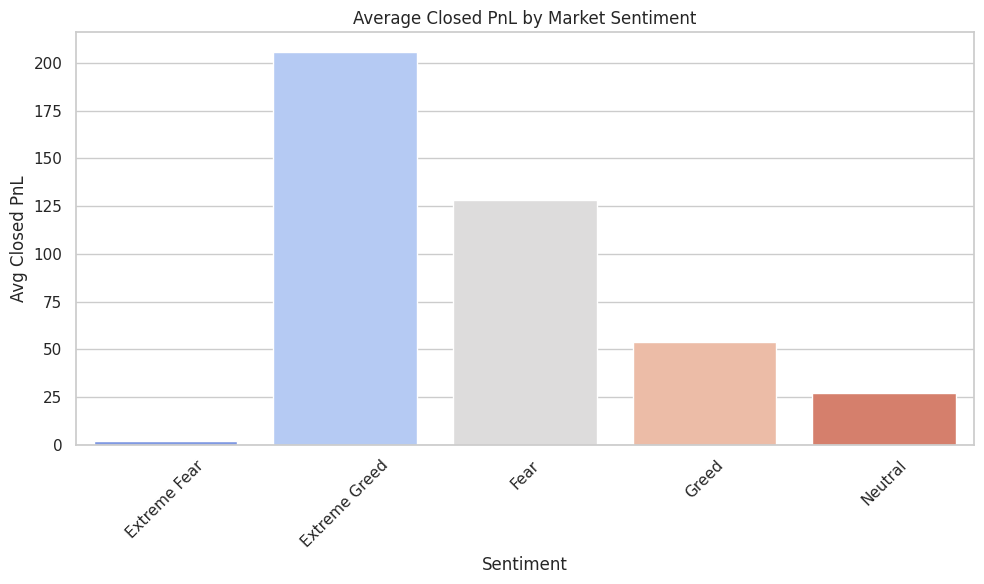

In [13]:
sns.barplot(data=summary_by_sentiment, x='classification', y='avg_closed_pnl', palette='coolwarm')
plt.title('Average Closed PnL by Market Sentiment')
plt.ylabel('Avg Closed PnL')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


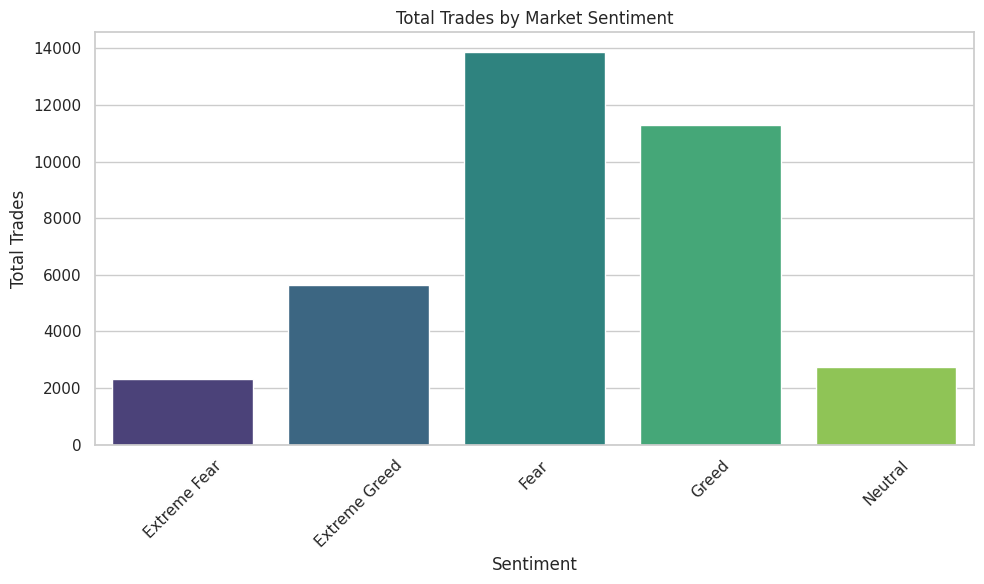

In [14]:
sns.barplot(data=summary_by_sentiment, x='classification', y='total_trades', palette='viridis')
plt.title('Total Trades by Market Sentiment')
plt.ylabel('Total Trades')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


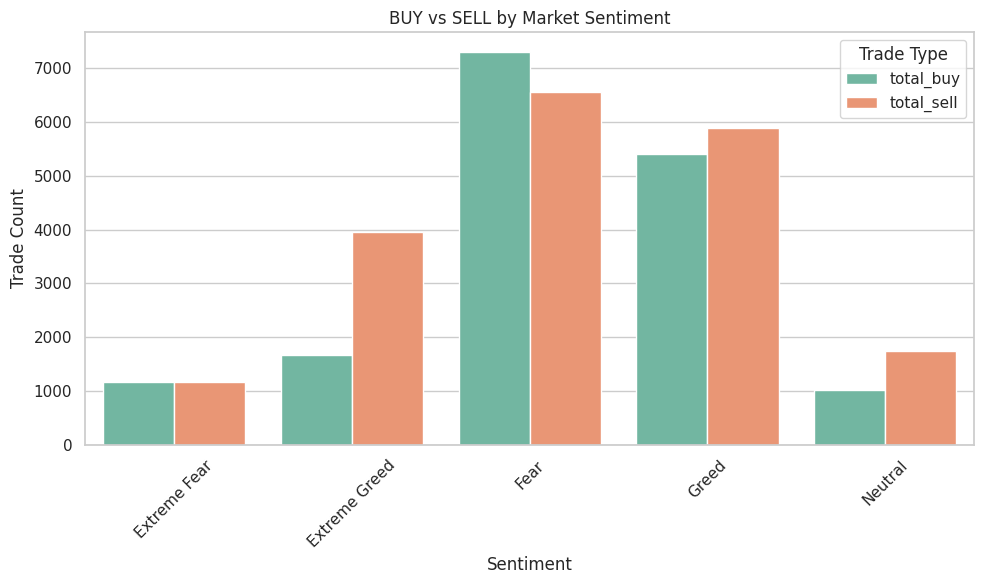

In [15]:
melted = summary_by_sentiment.melt(id_vars='classification',
                                   value_vars=['total_buy', 'total_sell'],
                                   var_name='Trade Type', value_name='Count')

sns.barplot(data=melted, x='classification', y='Count', hue='Trade Type', palette='Set2')
plt.title('BUY vs SELL by Market Sentiment')
plt.ylabel('Trade Count')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
# Save cleaned dataset
merged_df.to_csv("merged_trader_sentiment.csv", index=False)
summary_by_sentiment.to_csv("summary_by_sentiment.csv", index=False)


In [17]:
match_rate = (merged_df['classification'].notnull().mean()) * 100
print(f"Matched sentiment for {match_rate:.2f}% of trades")


Matched sentiment for 100.00% of trades


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


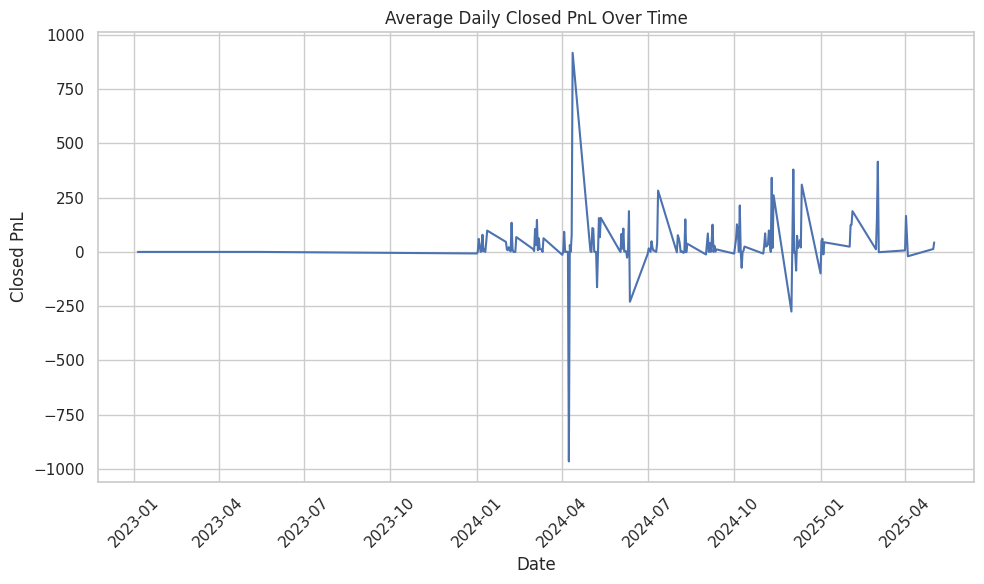

In [18]:
daily_pnl = merged_df.groupby('Date')['Closed PnL'].mean().reset_index()
plt.figure()
sns.lineplot(data=daily_pnl, x='Date', y='Closed PnL')
plt.title('Average Daily Closed PnL Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
account_sentiment_pnl = merged_df.groupby(['Account', 'classification'])['Closed PnL'].mean().reset_index()
top_accounts = account_sentiment_pnl.sort_values(by='Closed PnL', ascending=False).head(10)
print(top_accounts)


                                        Account classification   Closed PnL
96   0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  Extreme Greed  1037.288439
59   0x72c6a4624e1dffa724e6d00d64ceae698af892a0           Fear   996.439069
22   0x39cef799f8b69da1995852eea189df24eb5cae3c  Extreme Greed   744.269130
87   0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0          Greed   550.950039
1    0x083384f897ee0f19899168e3b1bec365f52a9012           Fear   502.539343
107  0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3           Fear   388.204726
104  0xbaaaf6571ab7d571043ff1e313a9609a10637864          Greed   252.845216
92   0xaf40fdc468c30116bd3307bcbf4a451a7ebf1deb   Extreme Fear   252.500000
51   0x513b8629fe877bb581bf244e326a047b249c4ff1          Greed   177.030131
29   0x420ab45e0bd8863569a5efbb9c05d91f40624641  Extreme Greed   176.246000


  classification  Side  Closed PnL
0   Extreme Fear   BUY   -3.248825
1   Extreme Fear  SELL    7.076480
2  Extreme Greed   BUY    9.047055
3  Extreme Greed  SELL  288.350131
4           Fear   BUY  210.426466
5           Fear  SELL   36.824047
6          Greed   BUY   15.661324
7          Greed  SELL   89.201657
8        Neutral   BUY   12.484274
9        Neutral  SELL   35.669805


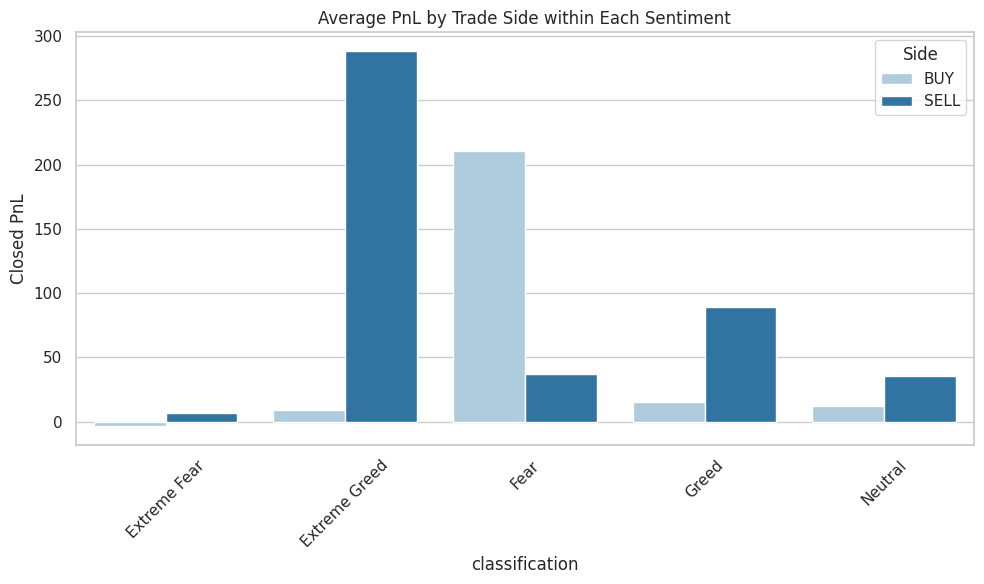

In [20]:
# Average PnL per sentiment & side
side_sentiment_pnl = merged_df.groupby(['classification', 'Side'])['Closed PnL'].mean().reset_index()
print(side_sentiment_pnl)

# Visualize
sns.barplot(data=side_sentiment_pnl, x='classification', y='Closed PnL', hue='Side', palette='Paired')
plt.title('Average PnL by Trade Side within Each Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


  classification  PnL Std Dev
0   Extreme Fear    76.727713
1  Extreme Greed  1861.557119
2           Fear  1342.348497
3          Greed  1399.468182
4        Neutral   142.945889


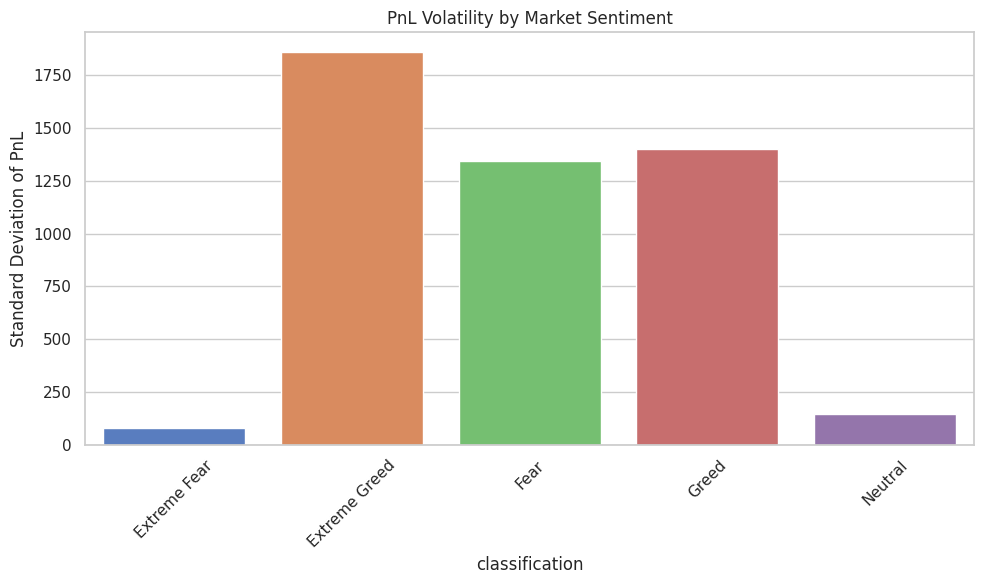

In [21]:
volatility_by_sentiment = merged_df.groupby('classification')['Closed PnL'].std().reset_index()
volatility_by_sentiment.columns = ['classification', 'PnL Std Dev']
print(volatility_by_sentiment)

# Visualize
sns.barplot(data=volatility_by_sentiment, x='classification', y='PnL Std Dev', palette='muted')
plt.title('PnL Volatility by Market Sentiment')
plt.ylabel('Standard Deviation of PnL')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [22]:
# Which accounts perform better in which sentiment?
account_perf = merged_df.groupby(['Account', 'classification'])['Closed PnL'].mean().reset_index()

# Find consistent profitable traders in Fear or Greed
top_fear_traders = account_perf[account_perf['classification'] == 'Fear'].sort_values(by='Closed PnL', ascending=False).head(5)
top_greed_traders = account_perf[account_perf['classification'] == 'Greed'].sort_values(by='Closed PnL', ascending=False).head(5)

print("Top Fear Traders:\n", top_fear_traders)
print("Top Greed Traders:\n", top_greed_traders)


Top Fear Traders:
                                         Account classification  Closed PnL
59   0x72c6a4624e1dffa724e6d00d64ceae698af892a0           Fear  996.439069
1    0x083384f897ee0f19899168e3b1bec365f52a9012           Fear  502.539343
107  0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3           Fear  388.204726
45   0x4f93fead39b70a1824f981a54d4e55b278e9f760           Fear  137.327338
101  0xb899e522b5715391ae1d4f137653e7906c5e2115           Fear  126.296648
Top Greed Traders:
                                         Account classification  Closed PnL
87   0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0          Greed  550.950039
104  0xbaaaf6571ab7d571043ff1e313a9609a10637864          Greed  252.845216
51   0x513b8629fe877bb581bf244e326a047b249c4ff1          Greed  177.030131
98   0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23          Greed  163.733156
16   0x2c229d22b100a7beb69122eed721cee9b24011dd          Greed  145.996529
